In [99]:
import sys
sys.path.append('..')
sys.path.append('../..')
from data_utils import *
from waveforms.make_waveform import BatchedLightSimulation

import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import importlib
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import yaml

from transformer import *
from hybrid_loss import *
from model import *
from evaluation import *
from conformer import *

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using CUDA

In [100]:
device='cuda'

MODEL_CLASSES = {
    "TransformerModel": TransformerModel,
    "ConformerModel": ConformerModel,
    "ConformerModelv2": ConformerModelv2,
    "UNet1D": UNet1D
}

def load_models(config_path, device="cuda"):
    with open(config_path, "r") as f:
        configs = yaml.safe_load(f)

    models = {}
    for name, cfg in configs.items():
        if not cfg.get("include", True):
            continue
            
        print(name)
        cls = MODEL_CLASSES[cfg["class"]]
        model = cls(**cfg.get("args", {}))
        model.to(device)

        checkpoint = torch.load(cfg["checkpoint"], map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        model.eval()

        models[name] = model
    return models
    
models = load_models("../model_list.yaml")
print(models.keys())  

conformer_v5_drop


/lscratch/carsmith/tmp/ipykernel_357321/4268378412.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(cfg["checkpoint"], map_location=device)


conformer_v5_+
dict_keys(['conformer_v5_drop', 'conformer_v5_+'])


In [101]:
# Loading in data
load_wfs = np.load('/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delta_t_500_passingflash.npy', allow_pickle=True) # array of shape (2519, 5, 250, 250)
dataset = WaveformDataset(load_wfs.item())

g = torch.Generator()
g.manual_seed(seed)

batch_size = 25

def custom_collate_fn(batch):
    """
    Custom collate function for WaveformDataset.
    Each item in batch is a tuple: (waveform, arrival_time).
    Returns:
        waveforms: Tensor of shape (batch_size, waveform_length)
        arrival_times: Tensor of shape (batch_size,) or (batch_size, 1)
        hit_times: Tensor of shape (?) with a list of hit times per sample
    """
    waveforms, arrival_times, hit_times, photon_bins, photon_list = zip(*batch)
    waveforms = torch.stack(waveforms, dim=0)

     # Normalizing waveforms
    waveforms = (waveforms - waveforms.mean(dim=1, keepdim=True)) / (waveforms.std(dim=1, keepdim=True) + 1e-8)
    waveforms = waveforms.unsqueeze(1)  # add channel dimension [B,1,L]

    # for binary classification
    arrival_times = torch.stack(arrival_times, dim=0)
    arrival_times = arrival_times.unsqueeze(1) # adding channel dimension
    photon_bins = torch.stack(photon_bins, dim=0)
    photon_bins = photon_bins.unsqueeze(1)

    # for regression, just use hit times
    hit_times = [item[2] for item in batch]
    hit_times = torch.tensor(hit_times)
    photon_list = [item[4] for item in batch]
    photon_list = torch.tensor(photon_list)
    
    return waveforms, arrival_times, hit_times, photon_bins, photon_list
    

delta_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    generator=g,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

### Collect & Order Waveforms and Predictions

In [102]:
# Animation of waveforms ordered by descending two-flash separation (one per separation value)

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import os

# ---------- User parameters ----------
save_mp4 = False            # set True to save mp4 (requires ffmpeg)
save_gif = True           # set True to also save GIF (uses Pillow)
out_dir = './animations'
out_name = '500phot_passing_NORM_conv5_drop'
fps = 24
waveform_channel = 0       # if waveform has channels, index of the 1D waveform channel
tick_scale_ns = 1.0        # conversion from tick index to ns (adjust if needed)
figsize = (10, 3)
normalize_each = False
# -------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models["conformer_v5_drop"]  # <-- replace with the name of the model you want to visualize
model.to(device)
model.eval()

os.makedirs(out_dir, exist_ok=True)

sep_to_example = {}

with torch.no_grad():
    for data, target, hit_times, photon_target, photon_list in tqdm(delta_loader):
        data = data.to(device)  # [B, 1, L]

        # Run the model on the whole batch
        class_output, reg_output = model(data, mode="bce")

        for b in range(data.shape[0]):
            ht = torch.tensor(hit_times[b]).flatten()
            valid_ht = ht[ht >= 0]

            if valid_ht.numel() == 2:
                # sep = int(abs((valid_ht[1] - valid_ht[0]).item()))  # separation in ticks
                sep = int((valid_ht[1] - valid_ht[0]).item()) # separation in ticks, CAN BE NEGATIVE
                if sep not in sep_to_example:  # only keep first example at this separation
                    wf = data[b].detach().cpu().squeeze().numpy()  # waveform as 1D numpy array

                    # compute merged mask for this waveform
                    merged_mask = merge_bins(class_output[b].unsqueeze(0), skip_tol=5)
                    sep_to_example[sep] = (wf, valid_ht.cpu().numpy(), merged_mask.cpu().numpy())

# ---------- Sort separations ----------
unique_seps = sorted(sep_to_example.keys(), reverse=True)
waveforms_ordered = [sep_to_example[s][0] for s in unique_seps]
hit_pairs = [sep_to_example[s][1] for s in unique_seps]
pred_masks = [sep_to_example[s][2] for s in unique_seps]
separations = unique_seps

print(f"Unique separations: {len(separations)}, max = {separations[0]}, min = {separations[-1]}")

# ---------- Normalize & ticks ----------
L = waveforms_ordered[0].shape[-1]
ticks = np.arange(L) * tick_scale_ns

if normalize_each:
    waveforms_plot = []
    for wf in waveforms_ordered:
        wf = np.array(wf)
        wf_norm = (wf - wf.mean()) / (wf.std() + 1e-8)
        waveforms_plot.append(wf_norm)
else:
    waveforms_plot = waveforms_ordered

# # ---------- Collect separations and one example per separation ----------
# sep_to_example = {}
# for i in range(len(dataset)):
#     wf, arrival_time, hit_times, *_ = dataset[i]
#     ht = torch.tensor(hit_times).flatten()
#     valid_ht = ht[ht >= 0]
#     if valid_ht.numel() == 2:
#         sep = int(abs((valid_ht[1] - valid_ht[0]).item()))  # separation in ticks
#         if sep not in sep_to_example:  # only keep first example at this separation
#             # store waveform as 1D numpy array
#             if isinstance(wf, torch.Tensor):
#                 wf_np = wf.squeeze().cpu().numpy()
#             else:
#                 wf_np = np.array(wf).squeeze()
#             sep_to_example[sep] = (wf_np, valid_ht.cpu().numpy())

# # Sort separations descending
# unique_seps = sorted(sep_to_example.keys(), reverse=True)
# waveforms_ordered = [sep_to_example[s][0] for s in unique_seps]
# hit_pairs = [sep_to_example[s][1] for s in unique_seps]
# separations = unique_seps

# print(f"Unique separations: {len(separations)}, max = {separations[0]}, min = {separations[-1]}")

# # Build Merged Windows
# pred_masks = []
# with torch.no_grad():
#     for wf in waveforms_ordered:
#         wf_tensor = torch.tensor(wf, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)  # [1,1,L]
#         class_output, reg_output = model(wf_tensor, mode="bce")
#         merged_mask = merge_bins(class_output, skip_tol=5)  # shape [L]
#         pred_masks.append(merged_mask.cpu().numpy())

# # ---------- Normalize & ticks ----------
# L = waveforms_ordered[0].shape[-1]
# ticks = np.arange(L) * tick_scale_ns

# if normalize_each:
#     waveforms_plot = []
#     for wf in waveforms_ordered:
#         wf = np.array(wf)
#         wf_norm = (wf - wf.mean()) / (wf.std() + 1e-8)
#         waveforms_plot.append(wf_norm)
# else:
#     waveforms_plot = waveforms_ordered

  0%|          | 0/4000 [00:00<?, ?it/s]/lscratch/carsmith/tmp/ipykernel_357321/3488047089.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ht = torch.tensor(hit_times[b]).flatten()
100%|██████████| 4000/4000 [01:58<00:00, 33.81it/s]


Unique separations: 2000, max = 999, min = -1000


### Sanity Check - Evaluate Purity on Selected Samples
START HERE! Try different batch sizes? to see if this changes things

In [103]:
print(len(pred_masks))
print(len(hit_pairs))
print(hit_pairs[0])

2000
2000
[4000 4999]


In [104]:
# Batching just to check
mask_tensor_list = [torch.tensor(mask).squeeze(0) for mask in pred_masks]  # each [1, 8000]
hit_pairs_arr = torch.tensor(hit_pairs)  # shape [N]

# Stack into one big tensor first
mask_tensor = torch.stack(mask_tensor_list)   # shape [N, 1, 8000]

batch_size = 25
num_batches = len(hit_pairs_arr) // batch_size  # 1500 // 25 = 60

# Make mask batches: [60, 25, 1, 8000]
mask_batches = mask_tensor[:num_batches * batch_size].view(num_batches, batch_size, 1, 8000)

# Make hit pair batches: [60, 25, 2]
hit_batches = hit_pairs_arr[:num_batches * batch_size].view(num_batches, batch_size, 2)

merged_pure = 0.0

# batched version
for i in range(mask_batches.shape[0]):
    merged_pure += merged_class_purity(mask_batches[i], hit_batches[i], device, no_sum=False)

merged_pure /= mask_batches.shape[0]
print("GIF Purity: ", merged_pure)

GIF Purity:  1.0004999999999995


In [105]:
merged_pure = 0.0
total_samples = 0

for i in range(mask_batches.shape[0]):
    batch_size = mask_batches[i].shape[0]
    merged_pure += merged_class_purity(mask_batches[i], hit_batches[i], device, no_sum=False) * batch_size
    total_samples += batch_size

merged_pure /= total_samples
print("GIF Purity (sample-weighted): ", merged_pure)


GIF Purity (sample-weighted):  1.0005000000000004


In [106]:
merged_pure = 0.0

# non-batched version
# for merged_mask, hit_times in zip(pred_masks, hit_pairs):
    #merged_mask = torch.tensor(merged_mask)
    #merged_pure += merged_class_purity(merged_mask, [hit_times], device, no_sum=False)

# batched version
for i in range(mask_batches.shape[0]):
    merged_pure += merged_class_purity(mask_batches[i], hit_batches[i], device, no_sum=False)

merged_pure /= mask_batches.shape[0]
print("GIF Purity: ", merged_pure)

GIF Purity:  1.0004999999999995


dict_keys(['conformer_v2', 'conformer_v5_drop', 'conformer_v5', 'conformer_5M', 'transformer_2M'])


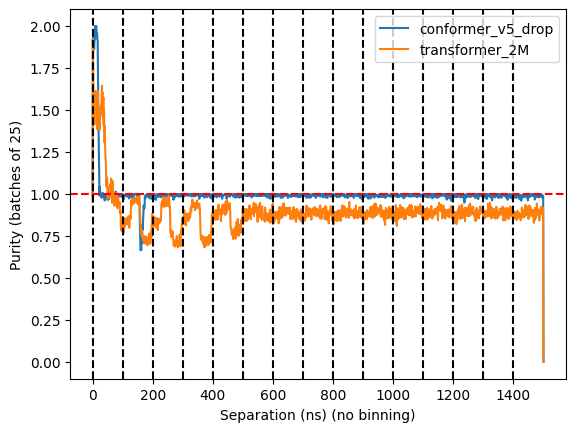

In [107]:
# loading in a pre-computed evaluation to compare purities
v5_drop_results = np.load("performance_analysis/delta_t_benchmark/conv5_drop_delta_t_results.npy", allow_pickle=True).item()
transformer_2M_results = np.load("performance_analysis/delta_t_benchmark/c5M_t2M_deltastats.npy", allow_pickle=True).item()

delta_results = {**v5_drop_results, **transformer_2M_results}

print(delta_results.keys())
plt.plot(delta_results['conformer_v5_drop']['merge_pure'], label='conformer_v5_drop')
plt.plot(delta_results['transformer_2M']['merge_pure'], label='transformer_2M')

for i in range(0, 1500, 100):
    plt.axvline(i, linestyle='--', color='black')
plt.axhline(1.0, linestyle='--', color='red')
plt.xlabel("Separation (ns) (no binning)")
plt.ylabel("Purity (batches of 25)")
plt.legend()

### Reshaping for Visualization

In [108]:
print(pred_masks[0])

[[[0 0 0 ... 0 0 0]]]


In [109]:
print(pred_masks[0].shape)
print(type(pred_masks[0]))
pred_masks = [mask.squeeze(1) for mask in pred_masks]
print(pred_masks[0].shape)

(1, 1, 8000)
<class 'numpy.ndarray'>
(1, 8000)


In [110]:
print(pred_masks[0][0, 3990:4010])
waveforms_plot = waveforms_plot[600:]

[0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0]


In [111]:
print(len(pred_masks))
pred_masks = pred_masks[600:]
print(len(pred_masks))

2000
1400


In [112]:
print(len(hit_pairs))
hit_pairs = hit_pairs[600:]
print(len(hit_pairs))

2000
1400


### Visualizing 1 Frame to Test

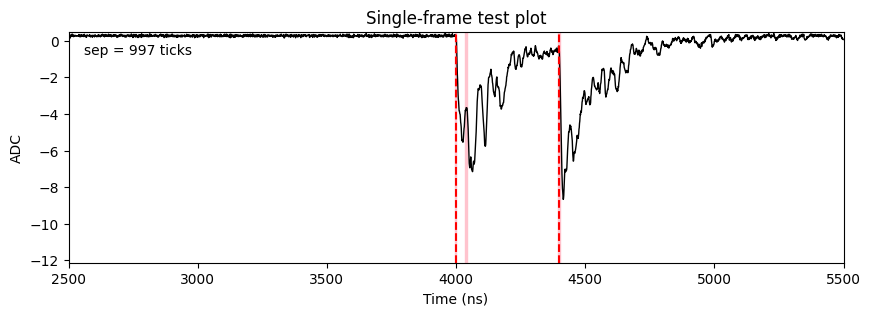

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# ---------- Precompute cropped region ----------
crop_start, crop_end = 2500, 5500
ticks = np.arange(crop_start, crop_end) * tick_scale_ns

waveforms_crop = [wf[crop_start:crop_end] for wf in waveforms_plot]
pred_masks_crop = [mask[0, crop_start:crop_end] for mask in pred_masks]

# ---------- Plot a single frame ----------
i = 2  # choose which waveform to show
wf = waveforms_crop[i]
pred = pred_masks_crop[i]

fig, ax = plt.subplots(1, 1, figsize=figsize)

# waveform
ax.plot(ticks, wf, lw=1, color='black')

# y-limits
ymin = min(np.min(wf) for wf in waveforms_crop)
ymax = max(np.max(wf) for wf in waveforms_crop)
ax.set_ylim(ymin, ymax)

ax.set_xlim(crop_start * tick_scale_ns, crop_end * tick_scale_ns)
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Normalized ADC" if normalize_each else "ADC")
ax.set_title("Single-frame test plot")

# Shade predicted regions (full height, pink)
inside = False
start = None
for j, val in enumerate(pred):
    if val == 1 and not inside:
        inside = True
        start = ticks[j]
    elif val == 0 and inside:
        inside = False
        end = ticks[j]
        ax.axvspan(start, end, ymin=0, ymax=1,
                   color="pink", alpha=0.9, zorder=-1)
if inside:
    ax.axvspan(start, ticks[-1], ymin=0, ymax=1,
               color="pink", alpha=0.9, zorder=-1)

# True hit vertical lines
h0, h1 = hit_pairs[i]
v0 = float(h0) * tick_scale_ns
v1 = float(h1) * tick_scale_ns
ax.axvline(v0, color="r", linestyle="--", linewidth=1.5)
ax.axvline(v1, color="r", linestyle="--", linewidth=1.5)

# add text
ax.text(0.02, 0.95, f"sep = {separations[i]} ticks",
        transform=ax.transAxes, va="top")

plt.show()

### Saving the Animation as a GIF

In [114]:
# ---------- Precompute cropped region ----------

crop_start, crop_end = 2500, 5500
ticks = np.arange(crop_start, crop_end) * tick_scale_ns

waveforms_crop = [wf[crop_start:crop_end] for wf in waveforms_plot]
pred_masks_crop = [mask[0, crop_start:crop_end] for mask in pred_masks]

# ---------- Animation ----------
fig, ax = plt.subplots(1, 1, figsize=figsize)
line, = ax.plot([], [], lw=1)
text_sep = ax.text(0.02, 0.95, '', transform=ax.transAxes, va='top')

ax.set_xlim(crop_start * tick_scale_ns, crop_end * tick_scale_ns)
ymin = min(np.min(wf) for wf in waveforms_crop)
ymax = max(np.max(wf) for wf in waveforms_crop)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Normalized ADC' if normalize_each else 'ADC')
ax.set_title('Waveforms: one example per separation (descending)')

# vertical lines for true hits
vline1 = ax.axvline(0, color='r', linestyle='--', linewidth=1.5)
vline2 = ax.axvline(0, color='r', linestyle='--', linewidth=1.5)

# storage for shaded spans so we can remove them each frame
shaded_regions = []

def init():
    line.set_data([], [])
    vline1.set_xdata([0])
    vline2.set_xdata([0])
    text_sep.set_text('')
    return (line, vline1, vline2, text_sep)

def animate(i):
    global shaded_regions
    # clear old shaded regions
    for patch in shaded_regions:
        patch.remove()
    shaded_regions = []

    wf = waveforms_crop[i]
    pred = pred_masks_crop[i]
    line.set_data(ticks, wf)

    inside = False
    start = None
    for j, val in enumerate(pred):
        if val == 1 and not inside:
            inside = True
            start = ticks[j]
        elif val == 0 and inside:
            inside = False
            end = ticks[j]
            shaded_regions.append(
                ax.axvspan(start, end, ymin=0, ymax=1,
                           color='pink', alpha=0.9, zorder=-1)
            )
    if inside:  # close final region
        shaded_regions.append(
            ax.axvspan(start, ticks[-1], ymin=0, ymax=1,
                       color='pink', alpha=0.9, zorder=-1)
        )

    # True hit vertical lines
    h0, h1 = hit_pairs[i]
    v0 = float(h0) * tick_scale_ns
    v1 = float(h1) * tick_scale_ns
    vline1.set_xdata([v0])
    vline2.set_xdata([v1])

    text_sep.set_text(f'sep = {separations[i]} ticks')
    return (line, vline1, vline2, text_sep, *shaded_regions)

nframes = 900
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=nframes, interval=1000/fps, blit=True)

plt.close(fig)

# ---------- Display in Jupyter ----------
HTML(anim.to_jshtml())

# ---------- Save ----------
if save_mp4:
    mp4_path = os.path.join(out_dir, out_name + '.mp4')
    print("Saving mp4 to:", mp4_path)
    anim.save(mp4_path, writer='ffmpeg', fps=fps)

if save_gif:
    gif_path = os.path.join(out_dir, out_name + '.gif')
    print("Saving gif to:", gif_path)
    anim.save(gif_path, writer='pillow', fps=fps)

Animation size has reached 20982285 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


Saving gif to: ./animations/500phot_passing_NORM_conv5_drop.gif
